### 1)라이브러리 불러오기, 데이터 확인하기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#sns Theme
sns.set_style('darkgrid')

#소수점 표현 제한
pd.set_option('display.float_format',lambda x:'{:.3f}'.format(x))

#디렉토리 내, 사용가능 파일 체크
from subprocess import check_output
#print(check_output(["ls", "../house"]).decode("utf8"))
#에러가 나서 #으로 표현했습니다!

In [2]:
train_df=pd.read_csv('house/train.csv')
test_df=pd.read_csv('house/train.csv')

In [3]:
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Save the ID column
train_ID=train_df['Id']
test_ID=test_df['Id']

#drop the ID column since it's unnecessary for prediction process
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

### 2) Data processing
1) Outliers

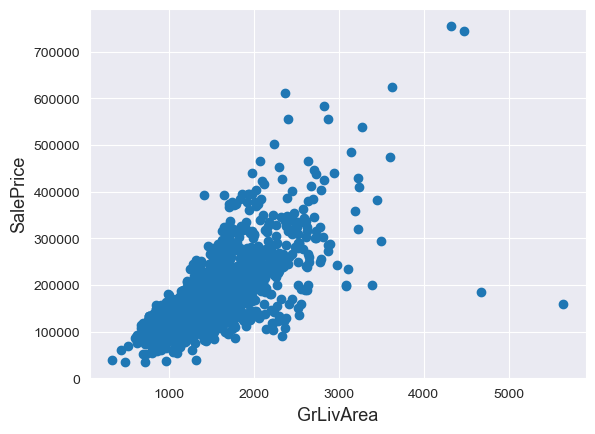

In [5]:
fig,ax=plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

낮은 SalePrice에서 그래프와 다르게 이상한 2개의 데이터를 확인 -> 삭제필요

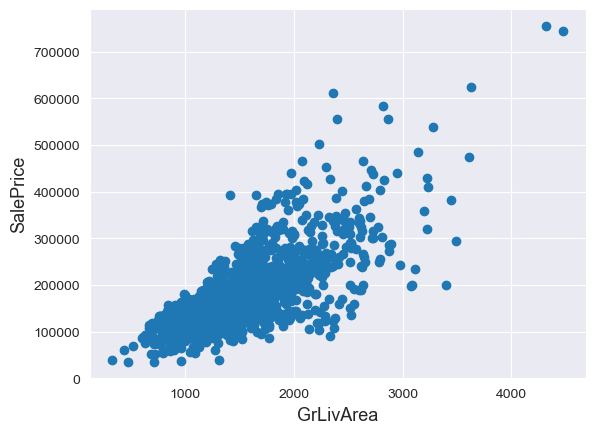

In [6]:
#Delecting outlier
train_df=train_df.drop(train_df[(train_df['GrLivArea']>4000)& (train_df['SalePrice']<300000)].index)

#Check the Graph again
fig,ax=plt.subplots()
ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

이상치를 일일이 제거하지 않는 이유
- 훈련 데이터에 이상치가 많을 수 있지만, 테스트 데이터에도 이상치가 있을 수 있음-> 않좋은 영향을 줌

2. Target Variabel 분석하기

180932.91906721535 79467.78892987774


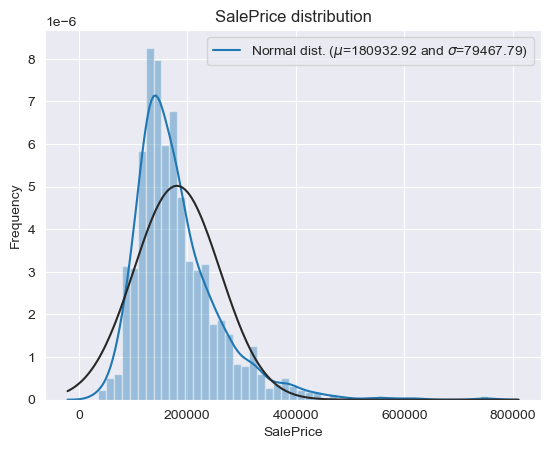

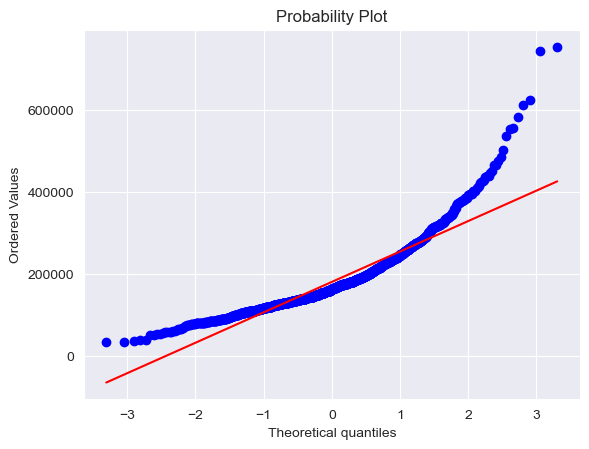

In [7]:
sns.distplot(train_df['SalePrice'], fit=norm)

#Get the fitted parameters used by the function
(mu, sigma)=norm.fit(train_df['SalePrice'])
print(mu,sigma)

#분포를 그래프에 그려봅시다.
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot을 그려봅시다.
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

분포가 오른쪽으로 치우침 -> log transformation 하기 log1p()이용

3. log transformation

12.024015155682552 0.3995757283645756


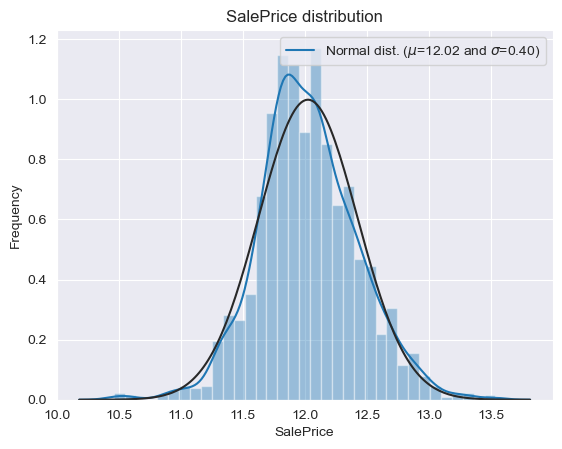

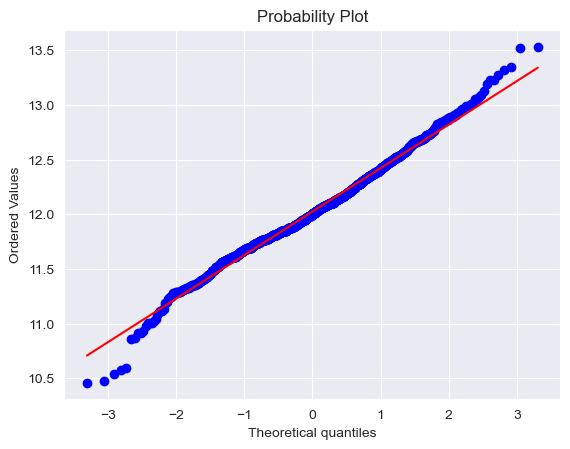

In [8]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

4. Feature Engineering

In [9]:
ntrain=train_df.shape[0]
ntest=test_df.shape[0]

y_train=train_df.SalePrice.values

all_data=pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2918, 79)


5. Missing Data

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.554
MiscFeature,96.299
Alley,93.763
Fence,80.740
MasVnrType,59.767
FireplaceQu,47.293
LotFrontage,17.752
GarageType,5.552
GarageYrBlt,5.552
GarageFinish,5.552


데이터 시각화

Text(0.5, 1.0, 'Percent missing data by feature')

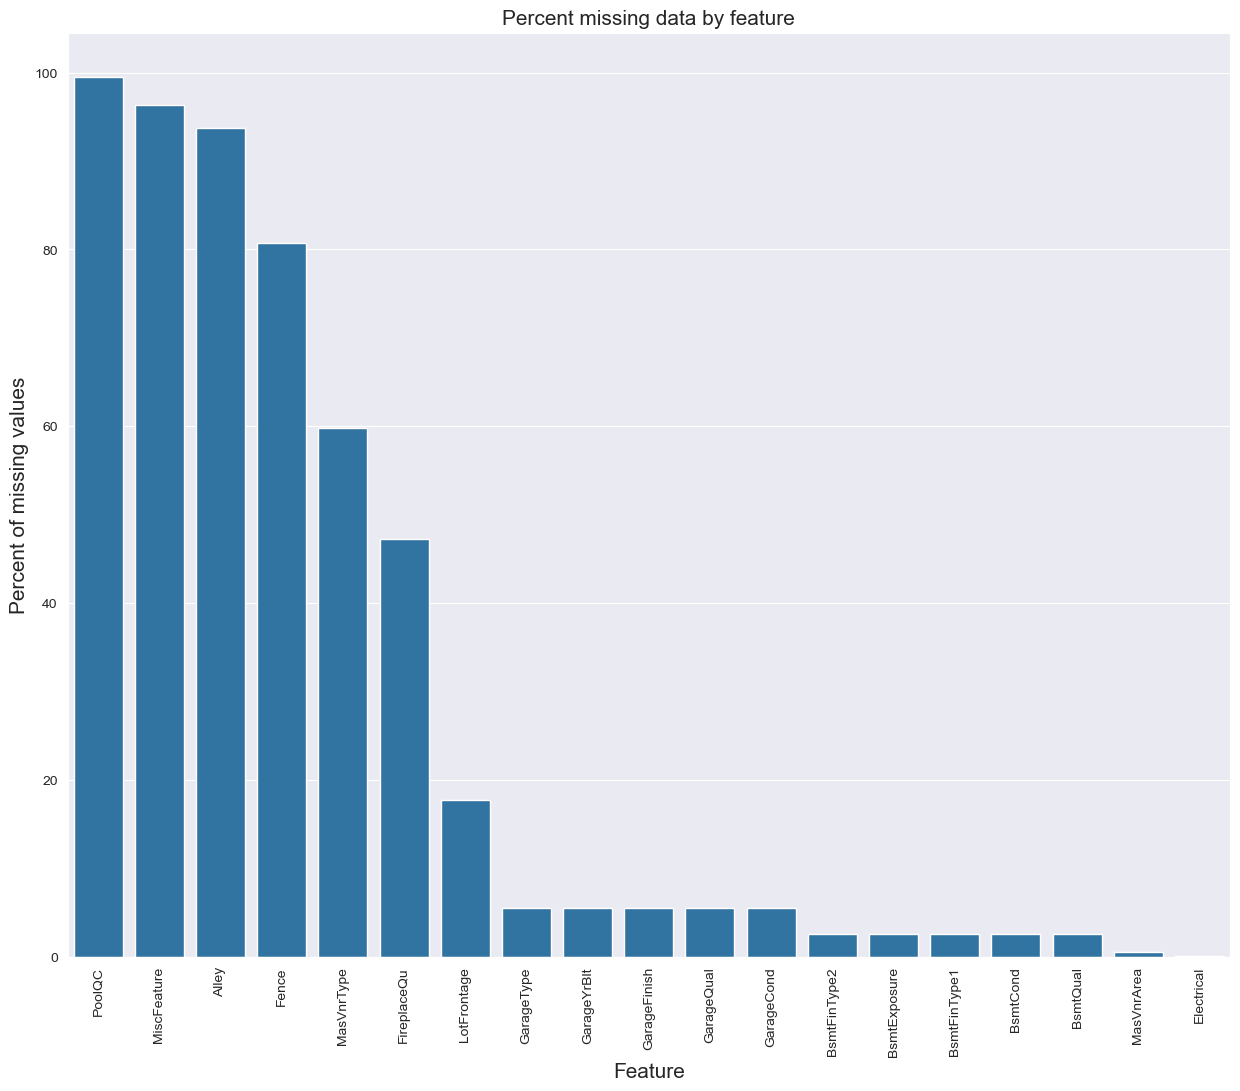

In [11]:
fig, ax=plt.subplots(figsize=(15,12))
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

6. Data Correlation
-heatmap : 각 요소의 상관관계 시각화

<Axes: >

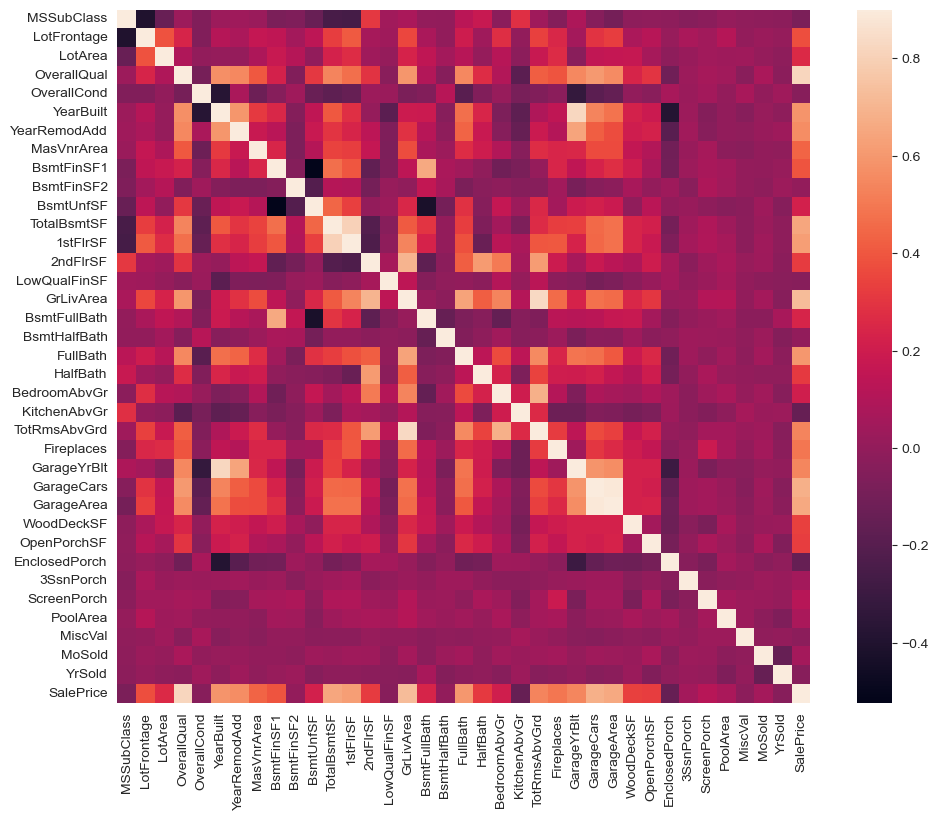

In [12]:
corrmat =train_df.corr(numeric_only=True)
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

7. Inputing missing values

- PoolQC,MiscFeature, Alley, Fence, FireplaceQu,GarageType, GarageFinish, GarageQual and GarageCond : NA로 처리
- LotFrontage, MSZoning: 중앙값으로 대체
- Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType : 최빈값으로

In [13]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [14]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [15]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

빈 데이터들을 'None' or 0으로 처리

In [17]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [21]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [22]:
all_data = all_data.drop(['Utilities'], axis=1)

In [23]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [24]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [25]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [26]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [27]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [28]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [29]:
#Check remaining missing values if any 
all_data_na=(all_data.isnull().sum()/len(all_data))*100
all_data_na=all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data=pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head()

,Missing Ratio


8. More feautre engineering
- 수치형 -> 범주형으로

In [30]:
# MSSubClass=The building class
all_data['MSSubClass']=all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

- 범주형 -> label encoding 이용

In [31]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lb1=LabelEncoder()
    lb1.fit(all_data[c].values)
    all_data[c]=lb1.transform(list(all_data[c].values))

#Shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2918, 78)


9. Adding one more important feature
- basement + 1층 + 2층 공간으로 새로운 특성 생성

In [32]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

10. Skewed Feature

In [33]:
numeric_feats=all_data.dtypes[all_data.dtypes !='object'].index

#수치형 데이터에서 skewness 체크
skewed_feats=all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)



Skew in numerical features: 



,Skew
MiscVal,24.443
PoolArea,15.345
LotArea,12.375
3SsnPorch,10.290
LowQualFinSF,8.999
LandSlope,4.807
KitchenAbvGr,4.482
BsmtFinSF2,4.249
ScreenPorch,4.116
BsmtHalfBath,4.098


11. Box-cox Transformation
- Box-Cox Transformation은 정규 분포가 아닌 데이터를 정규 분포 형태로 변환하는 방법

In [34]:
skewness=skewness[abs(skewness)>0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features=skewness.index
lam=0.15
for feat in skewed_features:
    all_data[feat]=boxcox1p(all_data[feat],lam)

There are 59 skewed numerical features to Box Cox transform


12. Get dummy categorical features

In [35]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

(2918, 221)


## 2) Modeling

In [36]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [37]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

LASSO Regression 이 모델은 이상치에 매우 민감하다

-kernel ridge regression

In [39]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

Gradient Boosting Regression
- huber 손실 함수로 이상치를 관리

In [40]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

XGBoost
- 하이퍼 파라미터 설정은 bayesian optimization을 사용

In [41]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [42]:
#LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

Base models scores  교차 검증을 통해 score를 구해본다

In [43]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1116 (0.0074)



In [45]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [46]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [47]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1169 (0.0070)



In [48]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[23:26:08] WARNING: C:\b\abs_7diruzi3as\croot\xgboost-split_1712794727514\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[23:26:20] WARNING: C:\b\abs_7diruzi3as\croot\xgboost-split_1712794727514\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[23:26:32] WARNING: C:\b\abs_7diruzi3as\croot\xgboost-split_1712794727514\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[23:26:45] WARNING: C:\b\abs_7diruzi3as\croot\xgboost-split_1712794727514\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[23:26:58] WARNING: C:\b\abs_7diruzi3as\croot\xgboost-split_1712794727514\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Xgboost score: 0.1170 (0.0056)



In [49]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

##### Stacking models
- 모델들의 성능을 평균하여 사용함.

In [50]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

ENet, GBoost, KRR and lasso를 이용해 score을 낸다.

In [51]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1087 (0.0074)



Less simple Stacking : Adding a Meta-model
- meta model을 추가하고, base model들의 평균과 이 out-of-folds 예측을 이용하여 meta-model을 훈련한다.

흐름
1. 훈련 데이터를 분리된 데이터셋 train, holdout으로 나눕니다.
2. train 데이터로 훈련을 하고
3. holdout 데이터로 테스트 합니다.
4. 3)을 통해 예측값을 구하고, meta model을 통해 그 예측 값으로 모델을 학습합니다.

In [52]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Stacking Averaged models Score
- 성능을 비교하기 위해 같은 모델을 이용하여 score를 만들어본다

In [53]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, KRR),
    meta_model=(lasso)
)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1084 (0.0074)


In [54]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Final Training and Prediction

In [55]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.0790773640428379


In [56]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

[23:45:07] WARNING: C:\b\abs_7diruzi3as\croot\xgboost-split_1712794727514\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

0.07870544453192344


In [57]:
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, m

In [58]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07591303381174651


In [59]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [60]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)